In [1]:
import os
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
import altair as alt
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression

In [2]:
# importing the oj dataset
os.chdir('/Users/noaht/OneDrive/Desktop/ECON_487')
data_oj = pl.read_csv('oj.csv')

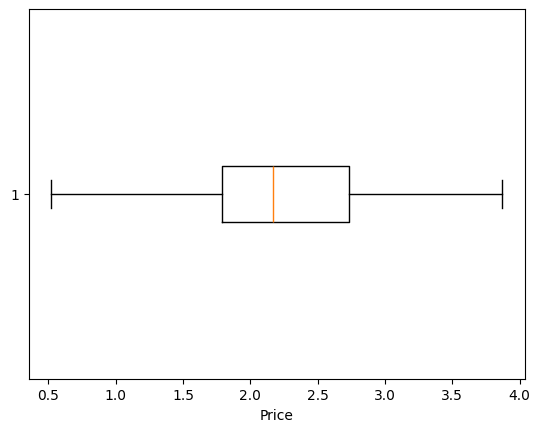

In [3]:
# boxplot of prices
prices = data_oj.select('price')
plt.boxplot(prices, orientation='horizontal')
plt.xlabel('Price')
plt.show()

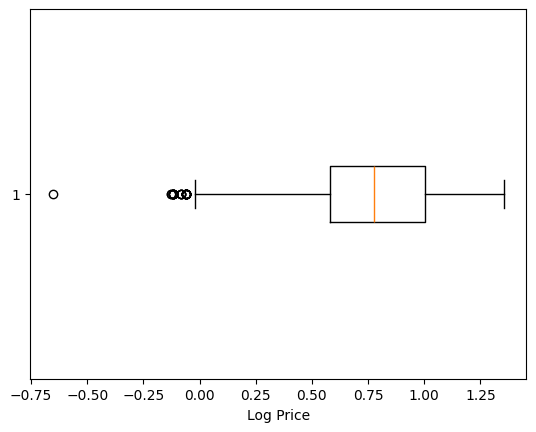

In [4]:
# box plot of log prices
data_oj = (
    data_oj
    .with_columns(pl.col('price').log().alias('log_price'))
    .with_row_index('row_nr')
)

log_prices = data_oj.select('log_price')
plt.boxplot(log_prices, orientation='horizontal')
plt.xlabel('Log Price')
plt.show()

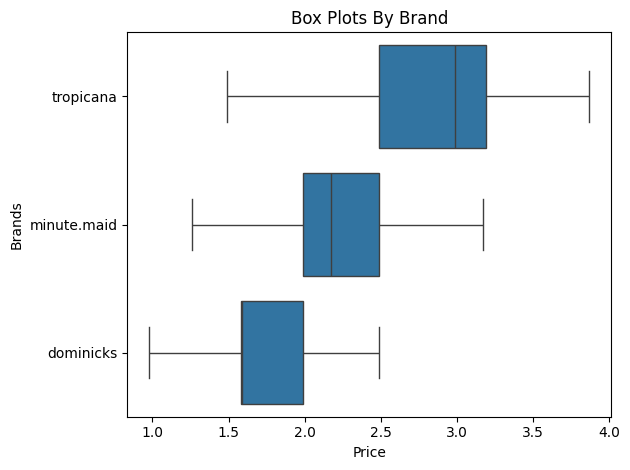

In [5]:
# boxplot grouped by brand
pd_oj = data_oj.to_pandas()

# sns is good at grouping stuff
sns.boxplot(
    data=pd_oj,
    x='price',
    y='brand',
    showfliers=False
)

# Axis titles
plt.xlabel('Price')
plt.ylabel('Brands')
plt.title('Box Plots By Brand')
plt.tight_layout()
plt.show()

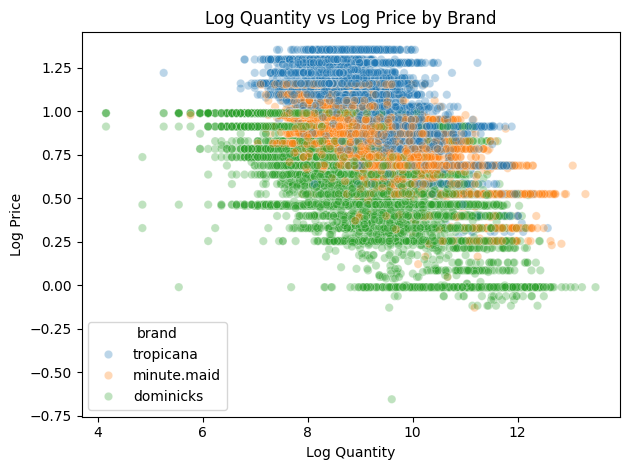

In [13]:
# scatterplot filtered by brand
pd_oj = data_oj.to_pandas()

sns.scatterplot(
    data=pd_oj,
    x='logmove',
    y='log_price',
    hue='brand',
    alpha=0.3
)

# Axis Labels
plt.xlabel('Log Quantity')
plt.ylabel('Log Price')
plt.title('Log Quantity vs Log Price by Brand')
plt.tight_layout()
plt.show()


In [ ]:
# Basic Linear Regression Model

# setting variables
pd_oj = data_oj.to_pandas()
basic_formula = 'logmove ~log_price'

# OLS
model_basic = smf.ols(formula=basic_formula, data=pd_oj).fit()
print(model_basic.summary())

## Model 1 "Demand" Curves

In [ ]:
# Prepare plotting data: remove nulls, convert to pandas
oj_plot_pd = (
    data_oj
    .drop_nulls(subset=["logmove", "log_price"])
    .to_pandas()
)

# scatterplot colored by brand 
fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(
    data=oj_plot_pd,
    x="logmove",
    y="log_price",
    hue="brand",
    alpha=0.3,
    ax=ax
)

# loop over each brand to draw "demand" curve
for brand, group in oj_plot_pd.groupby("brand"):
    # I want a smooth price line
    price_grid = np.linspace(group["log_price"].min(), group["log_price"].max(), 100)
    # prediction data
    pred_df = pd.DataFrame({
        "log_price": price_grid,
        # "brand": brand,
        # "feat": group["feat"].mean()
    })
    ax.plot(model_basic.predict(pred_df), price_grid)

ax.set_title("Visual Demand Curves by Brand")
plt.show()


In [ ]:
# 2nd model with brand where each brand gets its own intercept
m2_formula ='logmove ~ log_price + C(brand) - 1'

model_2 = smf.ols(formula=m2_formula, data=pd_oj).fit()
print(model_2.summary())

## Model 2 "Demand" Curves 

In [ ]:
# Prepare plotting data: remove nulls, convert to pandas
oj_plot_pd = (
    data_oj
    .drop_nulls(subset=["logmove", "log_price"])
    .to_pandas()
)

# scatterplot colored by brand 
fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(
    data=oj_plot_pd,
    x="logmove",
    y="log_price",
    hue="brand",
    alpha=0.3,
    ax=ax
)

# loop over each brand to draw "demand" curve
for brand, group in oj_plot_pd.groupby("brand"):
    # I want a smooth price line
    price_grid = np.linspace(group["log_price"].min(), group["log_price"].max(), 100)
    # prediction data
    pred_df = pd.DataFrame({
        "log_price": price_grid,
        "brand": brand,
        # "feat": group["feat"].mean()
    })
    ax.plot(model_2.predict(pred_df), price_grid)

ax.set_title("Visual Demand Curves by Brand")
plt.show()


In [ ]:
# model with interaction term
m3_formula = 'logmove ~log_price*C(brand)'

model_3 = smf.ols(formula=m3_formula, data=pd_oj).fit()
print(model_3.summary())

## Model 3 "Demand" Curves

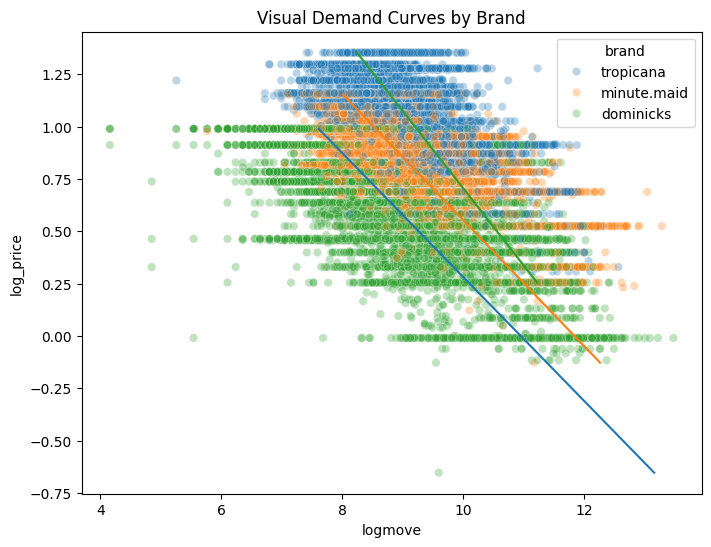

In [35]:
# Prepare plotting data: remove nulls, convert to pandas
oj_plot_pd = (
    data_oj
    .drop_nulls(subset=["logmove", "log_price"])
    .to_pandas()
)

# scatterplot colored by brand 
fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(
    data=oj_plot_pd,
    x="logmove",
    y="log_price",
    hue="brand",
    alpha=0.3,
    ax=ax
)

# loop over each brand to draw "demand" curve
for brand, group in oj_plot_pd.groupby("brand"):
    # I want a smooth price line
    price_grid = np.linspace(group["log_price"].min(), group["log_price"].max(), 100)
    # prediction data
    pred_df = pd.DataFrame({
        "log_price": price_grid,
        "brand": brand,
    })
    ax.plot(model_3.predict(pred_df), price_grid)

ax.set_title("Visual Demand Curves by Brand")
plt.show()


We can see that adding interaction terms shows us that tropicana's demand curve is more elastic than the simpler models suggest.
Also, sorry. I didn't change the colors of the prediction lines to correspond with the point colors 

In [ ]:
# average prices grouped by brand
# the percentage of each brand featured
price_feat = (
    data_oj
    .group_by(["brand"])
    .agg(
        pl.col("price").mean().alias("avg_price"),
        pl.col("feat").mean().alias("feat")
    )
    .sort(["brand"]) 
)
price_feat

In [ ]:
# add in feat as a variable since it obiviously has an effect
m4_formula = 'logmove ~log_price*C(brand) + feat'

model_4 = smf.ols(formula=m4_formula, data=pd_oj).fit()
print(model_4.summary())

In [ ]:
# add interaction term between log_price and feat but not between brand and feat
m5_formula = 'logmove ~ log_price + feat + log_price:feat + C(brand) + log_price:C(brand)'

model_5 = smf.ols(formula=m5_formula, data = pd_oj).fit()
print(model_5.summary())

In [ ]:
""""
interact all 3 because:
    Price sensitivity differs by brand (the coefficients are different)
    Does feat effect the overall elasticity?
        Does logmove change differently for a given price change if feat = 1?
    Feat seem to have a postitive effect on sales. Does the effect differ by brand?
"""
m6_formula = 'logmove ~ log_price*C(brand)*feat'

model_6 = smf.ols(formula=m6_formula, data = pd_oj).fit()
print(model_6.summary())

In [ ]:
""""
starting with the most sensible controls
    to kind've give a more complicated benchmark
"""
# adding in some other demographic variables
m7_formula = 'logmove ~ log_price*C(brand)*feat + ETHNIC + HHLARGE + WORKWOM + INCOME + AGE60'

model_7 = smf.ols(formula=m7_formula, data = pd_oj).fit()
print(model_7.summary())

In [ ]:
"""
Adding more variables to isolate true price effects and reduce bias
    controls to combat omitted variable bias
Goal right now: pure prediction
"""
m8_formula = 'logmove ~ log_price*C(brand)*feat + AGE60 + EDUC + ETHNIC + ' \
'INCOME + HHLARGE + WORKWOM + HVAL150 + SSTRDIST + SSTRVOL +' \
'CPDIST5 + CPWVOL5'

model_8 = smf.ols(formula=m8_formula, data = pd_oj).fit()
print(model_8.summary())

In [ ]:
# adding a y_hat column to the data
data_with_pred = data_oj.with_columns(pl.Series('y_hat', model_8.predict(pd_oj)))
"""
correlation matrix with Pearson correlation between predicted y and observed y
the diagonal entries aren't relevant because they always equal 1
""" 
f_r2 = float(np.corrcoef(data_with_pred['y_hat'], data_oj['logmove'])[0,1])
print(f"The fair R squared is {f_r2**2}.")

The fair R squared is 0.585148594187643.


In [64]:
# training data and test data
"""
randomly choose 80% to "train" the model on 
    Randomiztion so there's no Selection Bias
"""
oj_train = data_oj.sample(fraction=0.8, seed=487)
""" 
set aside the rest of the data points for testing
    use row_nr and "anti join" to identify which point's aren't in the training data
"""
oj_test = data_oj.join(oj_train.select("row_nr"), on="row_nr", how="anti")

In [65]:
# converting training and test data to pandas
pd_train = oj_train.to_pandas()
pd_test = oj_test.to_pandas()

# setting up the models using training data
"""
m8_formula = 'logmove ~ log_price*C(brand)*feat + AGE60 + EDUC + ETHNIC + ' \
'INCOME + HHLARGE + WORKWOM + HVAL150 + SSTRDIST + SSTRVOL +' \
'CPDIST5 + CPWVOL5'
"""
complex_model = smf.ols(formula=m8_formula, data=pd_train).fit()
"""
m6_formula = 'logmove ~ log_price*C(brand)*feat'
"""
simple_model = smf.ols(formula=m6_formula, data = pd_train).fit()

"""
y_hat_complex takes the demographic variables into account
y_hat_simple only takes feat, brand, and log price into account
"""
oj_train = oj_train.with_columns(
    pl.Series('y_hat_complex', complex_model.predict(pd_train)),
    pl.Series('y_hat_simple', simple_model.predict(pd_train))
)
# verify predictions by using the test data
oj_test = oj_test.with_columns(
    pl.Series('y_hat_complex_test', complex_model.predict(pd_test)),
    pl.Series('y_hat_simple_test', simple_model.predict(pd_test))
)

In [ ]:
# calculating the MSE for the training data
mse_train_complex = ((oj_train['y_hat_complex'] - oj_train['logmove']) ** 2).mean()
mse_train_simple = ((oj_train['y_hat_simple'] - oj_train['logmove']) ** 2).mean()

# calculating MSE for test data to verify
mse_test_complex = ((oj_test['y_hat_complex_test'] - oj_test['logmove']) ** 2).mean()
mse_test_simple = ((oj_test['y_hat_simple_test'] - oj_test['logmove']) ** 2).mean()

# comparing MSE's
print(
    f"- Train MSE with demographic variables included: {mse_train_complex:.3f} vs. excluded: {mse_train_simple:.3f}\n"
    f"- Test MSE with demographic variables included: {mse_test_complex:.3f} vs. excluded: {mse_test_simple:.3f}\n"
)

- Train MSE with demographic variables included: 0.433 vs. excluded: 0.485
- Test MSE with demographic variables included: 0.424 vs. excluded: 0.474



it's surprising that the test MSE's are better on both accounts (demographic variables included/exclded)
we can see that including demographic variables reduces MSE